# __AIFAKER__

## 노이즈 처리

__출력방식:__
- 원본 이미지, 노이즈 처리 이미지로 출력
- 노이즈 처리는 3단계로 구성됨
0.1, 0.3, 0.5 순서

### StyleGAN

✅ 보호된 이미지 저장 완료: ./Output/001_1_SGN.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_2_SGN.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_3_SGN.jpg


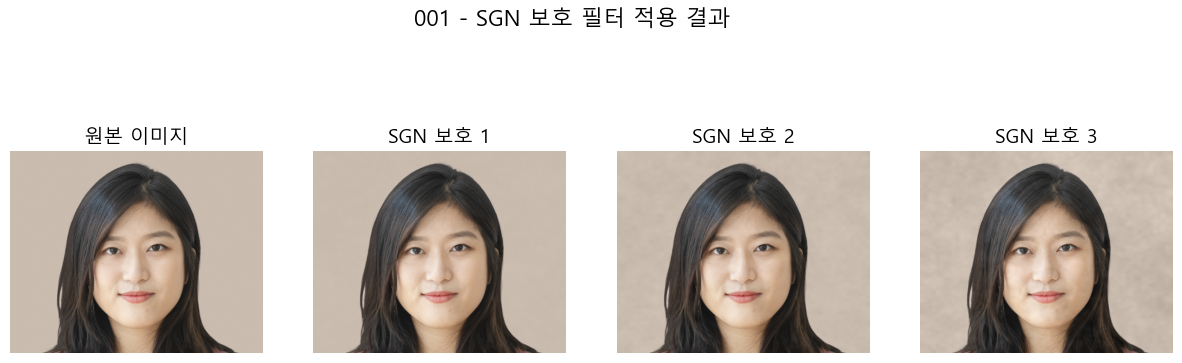

✅ 보호된 이미지 저장 완료: ./Output/002_1_SGN.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_2_SGN.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_3_SGN.jpg


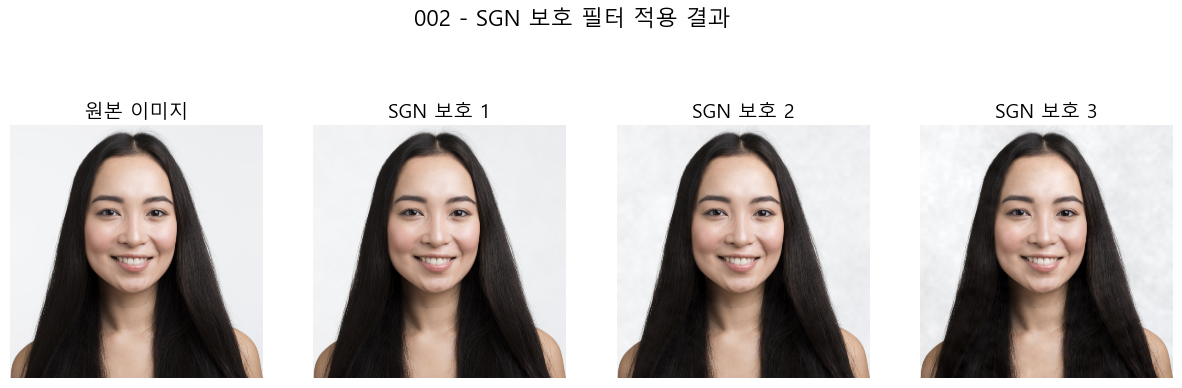

🎉 모든 StyleGAN 보호 이미지 저장 완료!


In [25]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def generate_protective_noise(image_size, strength=0.03):
    """스타일GAN 기반 보호 노이즈 생성"""
    noise_layers = []
    for scale in [4, 8, 16, 32, 64]:
        if scale <= image_size[0] and scale <= image_size[1]:
            noise = torch.randn(1, 1, scale, scale)
            upsampled = torch.nn.functional.interpolate(
                noise, size=image_size, mode='bilinear', align_corners=False
            ).squeeze(0)
            noise_layers.append(upsampled)

    combined_noise = sum(noise_layers) / len(noise_layers)
    return combined_noise.expand(3, -1, -1) * strength

def protect_image(image_path, output_base, noise_strength):
    """이미지에 StyleGAN 기반 보호 노이즈 적용 및 저장"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img)

    noise = generate_protective_noise((img_tensor.shape[1], img_tensor.shape[2]), strength=noise_strength)

    protected_img = img_tensor + noise
    protected_img = torch.clamp(protected_img, 0, 1)

    protected_pil = transforms.ToPILImage()(protected_img)
    output_path = f"{output_base}_SGN.jpg"
    protected_pil.save(output_path)
    print(f"✅ 보호된 이미지 저장 완료: {output_path}")

    return protected_pil

def display_images(original, protected_list, img_name, model_name):
    """보호 전/후 이미지 비교 출력"""
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("원본 이미지", fontsize=14)
    axes[0].axis("off")

    for i, protected in enumerate(protected_list):
        axes[i + 1].imshow(protected)
        axes[i + 1].set_title(f"{model_name} 보호 {i+1}", fontsize=14)
        axes[i + 1].axis("off")

    plt.suptitle(f"{img_name} - {model_name} 보호 필터 적용 결과", fontsize=16)
    plt.show()

def process_images(input_dir="./Input/", output_dir="./Output/", noise_levels=(0.01, 0.03, 0.05)):
    """입력 폴더의 모든 이미지에 StyleGAN 보호 노이즈 적용"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_formats = ("*.jpg", "*.jpeg", "*.png")
    image_paths = []
    for fmt in image_formats:
        image_paths.extend(glob.glob(os.path.join(input_dir, fmt)))

    if not image_paths:
        print("⚠️ 변환할 이미지가 없습니다.")
        return
    
    for img_path in image_paths:
        img_name, _ = os.path.splitext(os.path.basename(img_path))
        protected_images = []

        original = Image.open(img_path).convert("RGB")
        for i, noise_strength in enumerate(noise_levels, 1):
            output_base = os.path.join(output_dir, f"{img_name}_{i}")
            protected_pil = protect_image(img_path, output_base, noise_strength)
            protected_images.append(protected_pil)

        display_images(original, protected_images, img_name, "SGN")

    print("🎉 모든 StyleGAN 보호 이미지 저장 완료!")

# 실행
process_images()

### Stable Diffusion Noise

✅ 보호된 이미지 저장 완료: ./Output/001_1_SDN.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_2_SDN.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_3_SDN.jpg


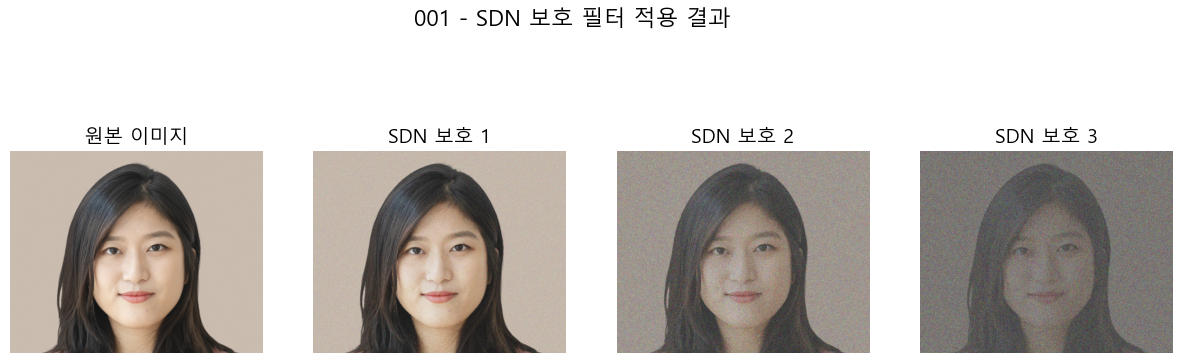

✅ 보호된 이미지 저장 완료: ./Output/002_1_SDN.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_2_SDN.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_3_SDN.jpg


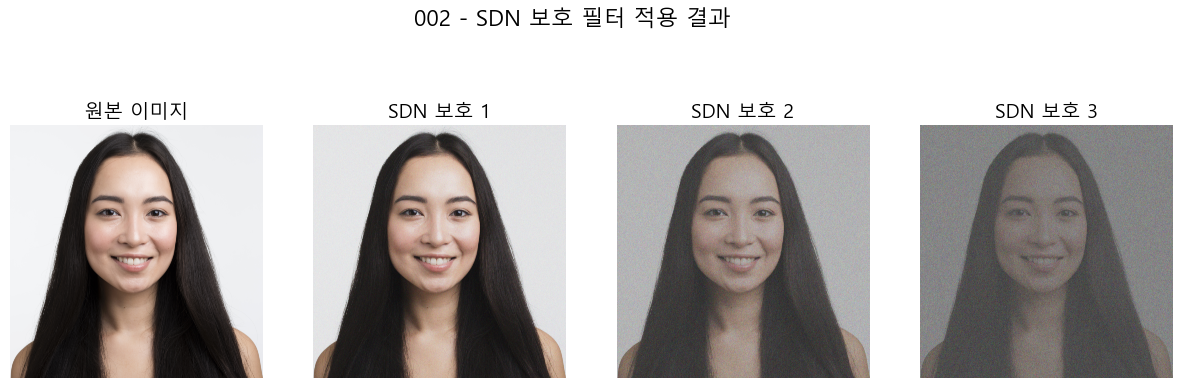

🎉 모든 Stable Diffusion 보호 이미지 저장 완료!


In [27]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from diffusers import DDPMScheduler

# 🔥 Stable Diffusion의 DDPMScheduler (Forward Diffusion 과정 사용)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="scaled_linear")

def apply_stable_diffusion_noise(image_tensor, noise_level):
    """Stable Diffusion의 Forward Diffusion 과정에서 노이즈 추가"""
    timesteps = torch.tensor([int(noise_level * len(scheduler.timesteps))], dtype=torch.long).to(image_tensor.device)
    noise = torch.randn_like(image_tensor)
    noisy_image = scheduler.add_noise(image_tensor, noise, timesteps)
    return torch.clamp(noisy_image, 0, 1)

def protect_image(image_path, output_base, noise_level):
    """이미지에 Stable Diffusion 기반 보호 노이즈 적용 후 저장"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    noisy_img_tensor = apply_stable_diffusion_noise(img_tensor, noise_level)
    noisy_pil = transforms.ToPILImage()(noisy_img_tensor.squeeze(0).cpu())

    output_path = f"{output_base}_SDN.jpg"
    noisy_pil.save(output_path)
    print(f"✅ 보호된 이미지 저장 완료: {output_path}")

    return noisy_pil

def display_images(original, protected_list, img_name, model_name):
    """보호 전/후 이미지 비교 출력"""
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("원본 이미지", fontsize=14)
    axes[0].axis("off")

    for i, protected in enumerate(protected_list):
        axes[i + 1].imshow(protected)
        axes[i + 1].set_title(f"{model_name} 보호 {i+1}", fontsize=14)
        axes[i + 1].axis("off")

    plt.suptitle(f"{img_name} - {model_name} 보호 필터 적용 결과", fontsize=16)
    plt.show()

def process_images(input_dir="./Input/", output_dir="./Output/", noise_levels=(0.1, 0.3, 0.5)):
    """입력 폴더의 모든 이미지에 Stable Diffusion 기반 노이즈 적용"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_formats = ("*.jpg", "*.jpeg", "*.png")
    image_paths = []
    for fmt in image_formats:
        image_paths.extend(glob.glob(os.path.join(input_dir, fmt)))

    if not image_paths:
        print("⚠️ 변환할 이미지가 없습니다.")
        return
    
    for img_path in image_paths:
        img_name, _ = os.path.splitext(os.path.basename(img_path))
        protected_images = []

        original = Image.open(img_path).convert("RGB")
        for i, noise_level in enumerate(noise_levels, 1):
            output_base = os.path.join(output_dir, f"{img_name}_{i}")
            protected_pil = protect_image(img_path, output_base, noise_level)
            protected_images.append(protected_pil)

        display_images(original, protected_images, img_name, "SDN")

    print("🎉 모든 Stable Diffusion 보호 이미지 저장 완료!")

# 실행
process_images()

### Denoising Diffusion Noise Injection

In [31]:
!pip install torch torchvision diffusers transformers accelerate matplotlib

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------- 10.0/10.0 MB 47.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 17.0 MB/s eta 0:00:00


✅ 보호된 이미지 저장 완료: ./Output/001_1_DDPM.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_2_DDPM.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_3_DDPM.jpg


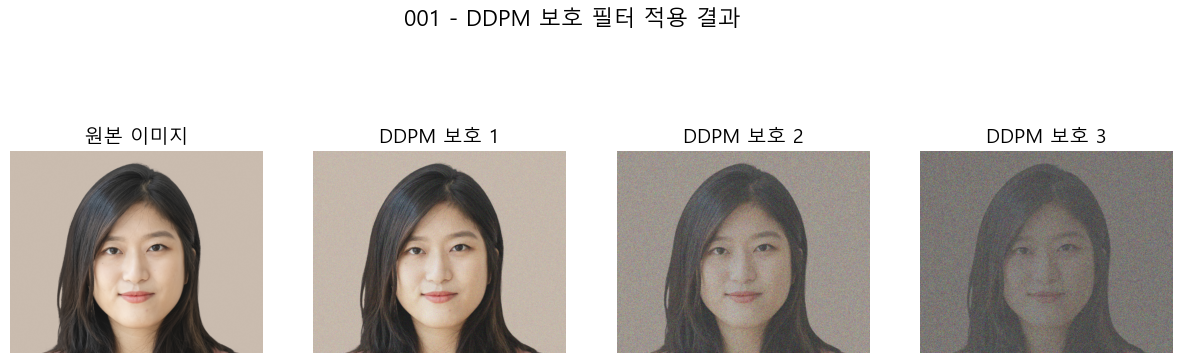

✅ 보호된 이미지 저장 완료: ./Output/002_1_DDPM.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_2_DDPM.jpg
✅ 보호된 이미지 저장 완료: ./Output/002_3_DDPM.jpg


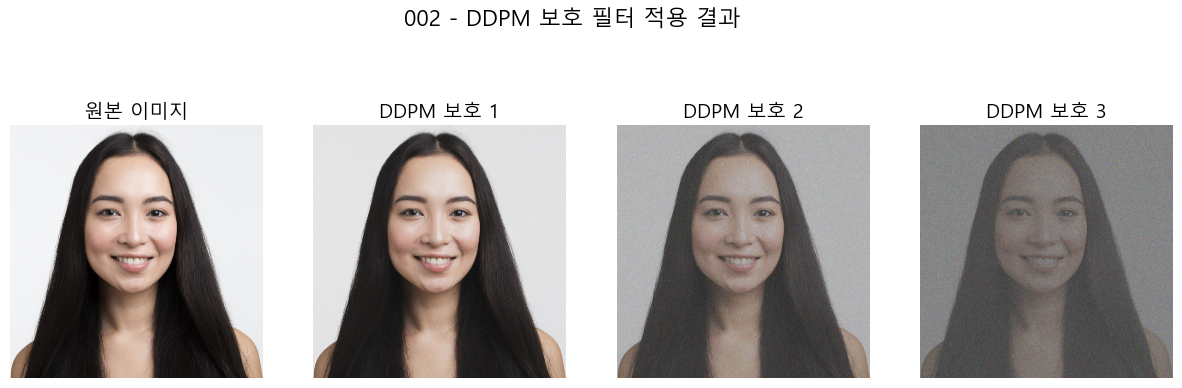

🎉 모든 DDPM 보호 이미지 저장 완료!


In [32]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from diffusers import DDPMScheduler

# 🔥 DDPM Forward Diffusion을 위한 스케줄러 설정
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="scaled_linear")

def apply_ddpm_noise(image_tensor, noise_level):
    """DDPM Forward Diffusion 방식으로 노이즈 추가"""
    timesteps = torch.tensor([int(noise_level * len(scheduler.timesteps))], dtype=torch.long).to(image_tensor.device)
    noise = torch.randn_like(image_tensor)  # 가우시안 노이즈 생성
    noisy_image = scheduler.add_noise(image_tensor, noise, timesteps)  # 노이즈 적용
    return torch.clamp(noisy_image, 0, 1)  # 0~1 범위로 클램핑

def protect_image(image_path, output_base, noise_level):
    """이미지에 DDPM 기반 보호 노이즈 적용 후 저장"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    noisy_img_tensor = apply_ddpm_noise(img_tensor, noise_level)
    noisy_pil = transforms.ToPILImage()(noisy_img_tensor.squeeze(0).cpu())

    output_path = f"{output_base}_DDPM.jpg"
    noisy_pil.save(output_path)
    print(f"✅ 보호된 이미지 저장 완료: {output_path}")

    return noisy_pil

def display_images(original, protected_list, img_name, model_name):
    """보호 전/후 이미지 비교 출력"""
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("원본 이미지", fontsize=14)
    axes[0].axis("off")

    for i, protected in enumerate(protected_list):
        axes[i + 1].imshow(protected)
        axes[i + 1].set_title(f"{model_name} 보호 {i+1}", fontsize=14)
        axes[i + 1].axis("off")

    plt.suptitle(f"{img_name} - {model_name} 보호 필터 적용 결과", fontsize=16)
    plt.show()

def process_images(input_dir="./Input/", output_dir="./Output/", noise_levels=(0.1, 0.3, 0.5)):
    """입력 폴더의 모든 이미지에 DDPM 기반 노이즈 적용"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_formats = ("*.jpg", "*.jpeg", "*.png")
    image_paths = []
    for fmt in image_formats:
        image_paths.extend(glob.glob(os.path.join(input_dir, fmt)))

    if not image_paths:
        print("⚠️ 변환할 이미지가 없습니다.")
        return
    
    for img_path in image_paths:
        img_name, _ = os.path.splitext(os.path.basename(img_path))
        protected_images = []

        original = Image.open(img_path).convert("RGB")
        for i, noise_level in enumerate(noise_levels, 1):
            output_base = os.path.join(output_dir, f"{img_name}_{i}")
            protected_pil = protect_image(img_path, output_base, noise_level)
            protected_images.append(protected_pil)

        display_images(original, protected_images, img_name, "DDPM")

    print("🎉 모든 DDPM 보호 이미지 저장 완료!")

# 실행
process_images()


### Universal Adversarial Perturbations
FGSM(Fast Gradient Sign Method) 기반

In [34]:
!pip install torch torchvision matplotlib numpy

✅ 보호된 이미지 저장 완료: ./Output/001_1_UAP.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_2_UAP.jpg
✅ 보호된 이미지 저장 완료: ./Output/001_3_UAP.jpg


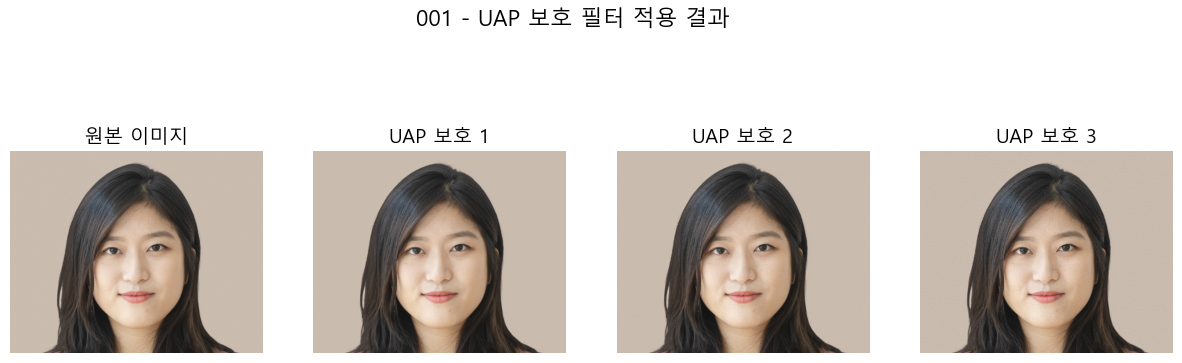

: 

In [37]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

# 🔥 FGSM 기반 Universal Adversarial Perturbation 생성 함수
def generate_uap(model, images, epsilon=0.1):
    """FGSM을 사용하여 Universal Adversarial Perturbation 생성"""
    model.eval()
    images = images.to("cuda" if torch.cuda.is_available() else "cpu").detach().clone().requires_grad_(True)

    # 원본 이미지의 예측 결과 가져오기
    output = model(images)
    target = output.argmax(dim=1)  # 예측된 클래스

    # 손실 함수 설정
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(output, target)

    # 그래디언트 계산
    model.zero_grad()
    loss.backward()

    # FGSM 방식으로 적대적 노이즈 생성
    perturbation = epsilon * images.grad.sign()
    return perturbation.detach()

def apply_uap(image_tensor, uap):
    """생성된 UAP를 이미지에 적용"""
    perturbed_image = image_tensor + uap
    return torch.clamp(perturbed_image, 0, 1)  # 0~1 범위로 클램핑

def protect_image(image_path, output_base, epsilon):
    """UAP 기반 보호 노이즈 적용 후 저장"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    # Pre-trained 모델 (ResNet) 사용하여 UAP 생성
    model = models.resnet50(pretrained=True).to("cuda" if torch.cuda.is_available() else "cpu")
    uap = generate_uap(model, img_tensor, epsilon)

    # 노이즈 적용
    noisy_img_tensor = apply_uap(img_tensor, uap)
    noisy_pil = transforms.ToPILImage()(noisy_img_tensor.squeeze(0).cpu())

    output_path = f"{output_base}_UAP.jpg"
    noisy_pil.save(output_path)
    print(f"✅ 보호된 이미지 저장 완료: {output_path}")

    return noisy_pil

def display_images(original, protected_list, img_name, model_name):
    """보호 전/후 이미지 비교 출력"""
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("원본 이미지", fontsize=14)
    axes[0].axis("off")

    for i, protected in enumerate(protected_list):
        axes[i + 1].imshow(protected)
        axes[i + 1].set_title(f"{model_name} 보호 {i+1}", fontsize=14)
        axes[i + 1].axis("off")

    plt.suptitle(f"{img_name} - {model_name} 보호 필터 적용 결과", fontsize=16)
    plt.show()

def process_images(input_dir="./Input/", output_dir="./Output/", noise_levels=(0.01, 0.03, 0.05)):
    """입력 폴더의 모든 이미지에 UAP 기반 노이즈 적용"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_formats = ("*.jpg", "*.jpeg", "*.png")
    image_paths = []
    for fmt in image_formats:
        image_paths.extend(glob.glob(os.path.join(input_dir, fmt)))

    if not image_paths:
        print("⚠️ 변환할 이미지가 없습니다.")
        return
    
    for img_path in image_paths:
        img_name, _ = os.path.splitext(os.path.basename(img_path))
        protected_images = []

        original = Image.open(img_path).convert("RGB")
        for i, epsilon in enumerate(noise_levels, 1):
            output_base = os.path.join(output_dir, f"{img_name}_{i}")
            protected_pil = protect_image(img_path, output_base, epsilon)
            protected_images.append(protected_pil)

        display_images(original, protected_images, img_name, "UAP")

    print("🎉 모든 UAP 보호 이미지 저장 완료!")

# 실행
process_images()

## 검증

In [20]:
!pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.9 MB 24.6 MB/s eta 0:00:01
   ----- ---------------------------------- 1.8/12.9 MB 4.2 MB/s eta 0:00:03
   ------------ --------------------------- 3.9/12.9 MB 6.3 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.9 MB 6.3 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.9 MB 6.3 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.9 MB 6.3 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.9 MB 6.3 MB/s eta 0:00:02
   ----------------- ---------------------- 5.5/12.9 MB 3.2 MB/s eta 0:00:03
   ----------------- ---------------------- 5.5/12.9 MB 3.2 MB/s eta 0:00:03
   ----------------- ---------------------- 5.5/12.9 MB 3.2 MB/s eta 0:00:03
   ----------------- ---------------------- 5.5/12.9 MB 3.2 MB/s eta 0:00:03
   ---------

### PSNR (Peak Signal-to-Noise Ratio) & SSIM (Structural Similarity) 계산

__목표:__

- PSNR (신호 대 잡음비): 원본과 변형된 이미지의 유사도 측정 (값이 클수록 원본과 유사)
- SSIM (구조적 유사도): 이미지의 구조적 차이를 정량화 (값이 1에 가까울수록 원본과 유사)
검증 방법:

- PSNR이 낮으면 노이즈가 강하게 적용된 것
- SSIM이 낮으면 원본과 구조적으로 차이가 많아진 것

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_psnr_ssim(original, noisy):
    """PSNR 및 SSIM 계산"""
    original = np.array(original.convert("L"))  # 흑백 변환
    noisy = np.array(noisy.convert("L"))  # 흑백 변환

    # PSNR 계산
    mse = np.mean((original - noisy) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')

    # SSIM 계산
    ssim_value = ssim(original, noisy, data_range=noisy.max() - noisy.min())

    return psnr, ssim_value

def validate_output(original, protected_list):
    """각 보호된 이미지에 대해 PSNR 및 SSIM 평가"""
    for i, protected in enumerate(protected_list):
        psnr, ssim_value = calculate_psnr_ssim(original, protected)
        print(f"🔹 노이즈 단계 {i+1}: PSNR={psnr:.2f}, SSIM={ssim_value:.4f}")

### Robustness Test

__목표:__

- 원본 이미지와 노이즈 이미지가 AI 모델에서 같은 클래스로 예측되는지 확인
- 이미지 분류 모델 (ResNet, EfficientNet) 등을 사용해 비교

__검증 방법:__

- Pre-trained 모델 (ResNet50 등) 사용
- 원본 vs. 노이즈 이미지 각각 예측
- 노이즈 강도가 올라갈수록 예측 정확도가 낮아지는지 확인

In [23]:
import torch
import torchvision.models as models
import torchvision.transforms as T

# Pre-trained ResNet 모델 로드
model = models.resnet50(pretrained=True)
model.eval()

def predict_image(image):
    """이미지를 ResNet 모델을 사용하여 분류"""
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가
    with torch.no_grad():
        output = model(image_tensor)
    
    return torch.argmax(output).item()

def evaluate_model_robustness(original, protected_list):
    """원본 및 보호된 이미지의 분류 결과 비교"""
    original_label = predict_image(original)
    print(f"🖼️ 원본 이미지 예측 라벨: {original_label}")

    for i, protected in enumerate(protected_list):
        noisy_label = predict_image(protected)
        print(f"🔹 노이즈 {i+1}단계 예측 라벨: {noisy_label}")


📌 **001 (원본 이미지) 검증 결과**
🔍 AI 모델 예측: 903


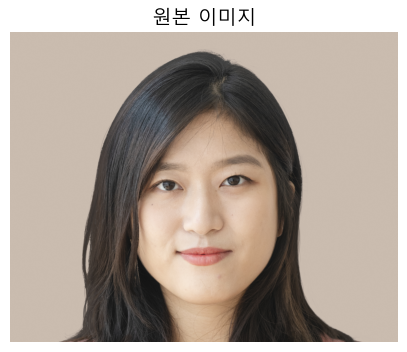


🎨 **DDPM 모델**


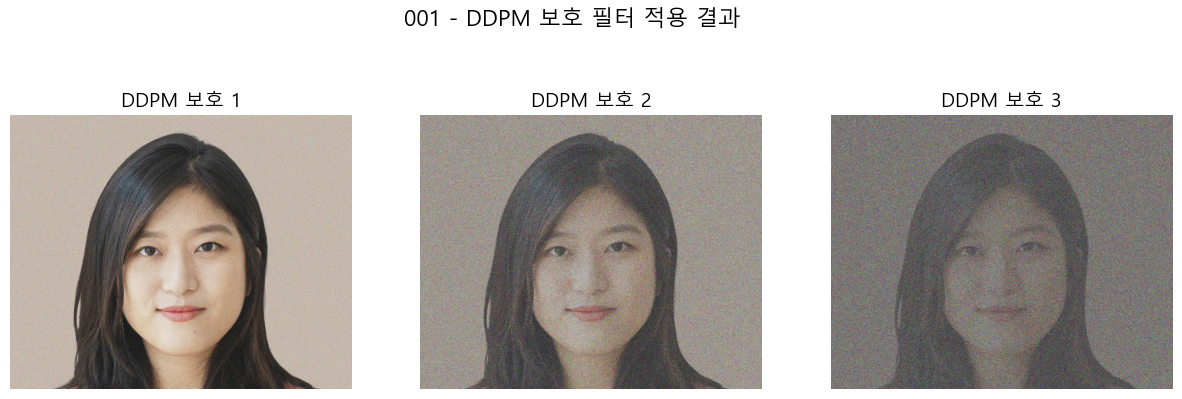

📌 **DDPM_1**
  - PSNR: 28.24
  - SSIM: 0.1205
  - AI 모델 예측: 903

📌 **DDPM_2**
  - PSNR: 27.92
  - SSIM: 0.0265
  - AI 모델 예측: 903

📌 **DDPM_3**
  - PSNR: 27.87
  - SSIM: 0.0151
  - AI 모델 예측: 501


🎨 **SDN 모델**


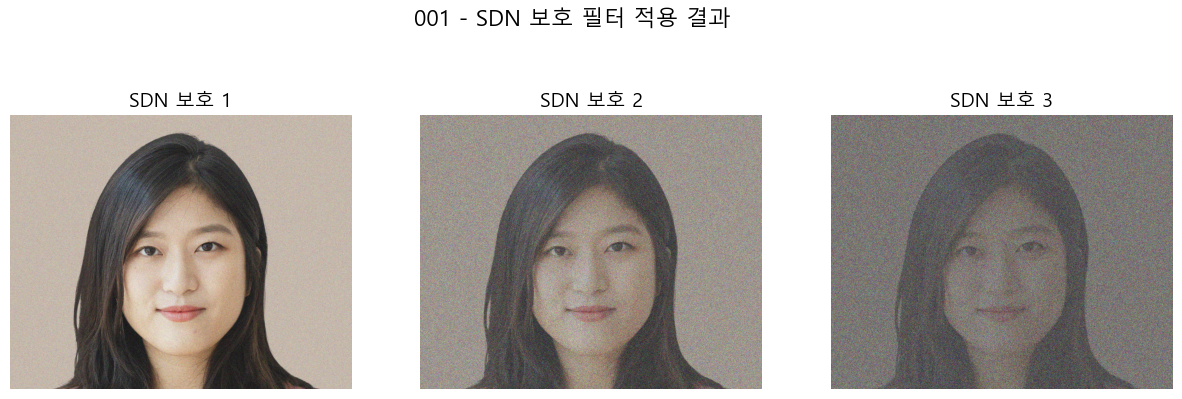

📌 **SDN_1**
  - PSNR: 28.24
  - SSIM: 0.1206
  - AI 모델 예측: 903

📌 **SDN_2**
  - PSNR: 27.91
  - SSIM: 0.0266
  - AI 모델 예측: 903

📌 **SDN_3**
  - PSNR: 27.87
  - SSIM: 0.0150
  - AI 모델 예측: 501


🎨 **SGN 모델**


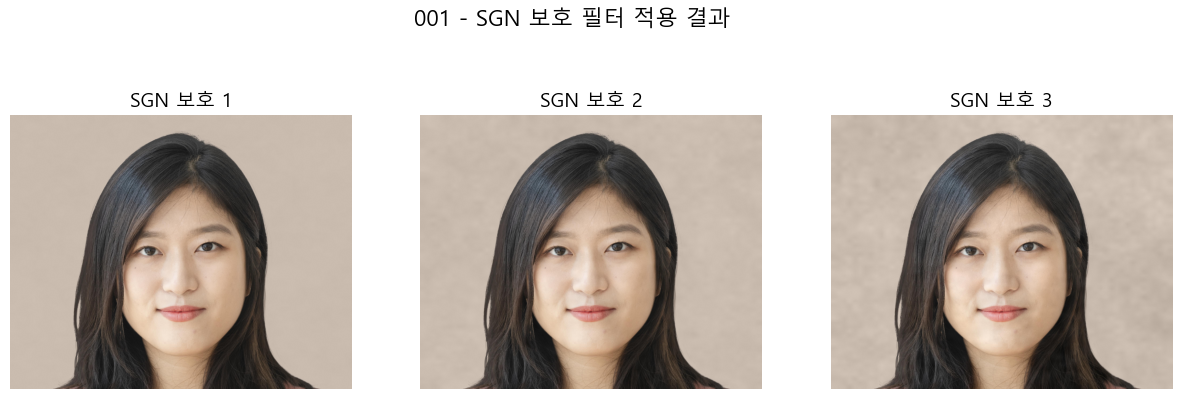

📌 **SGN_1**
  - PSNR: 40.91
  - SSIM: 0.9562
  - AI 모델 예측: 459

📌 **SGN_2**
  - PSNR: 38.45
  - SSIM: 0.9549
  - AI 모델 예측: 445

📌 **SGN_3**
  - PSNR: 34.57
  - SSIM: 0.9539
  - AI 모델 예측: 445


📌 **002 (원본 이미지) 검증 결과**
🔍 AI 모델 예측: 903


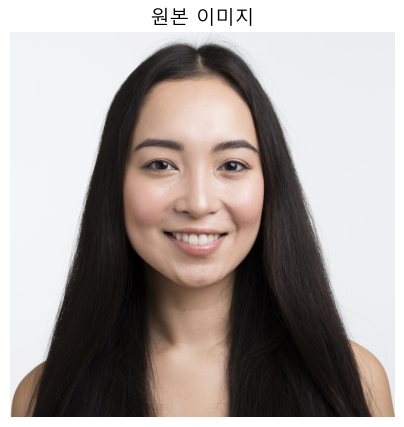


🎨 **DDPM 모델**


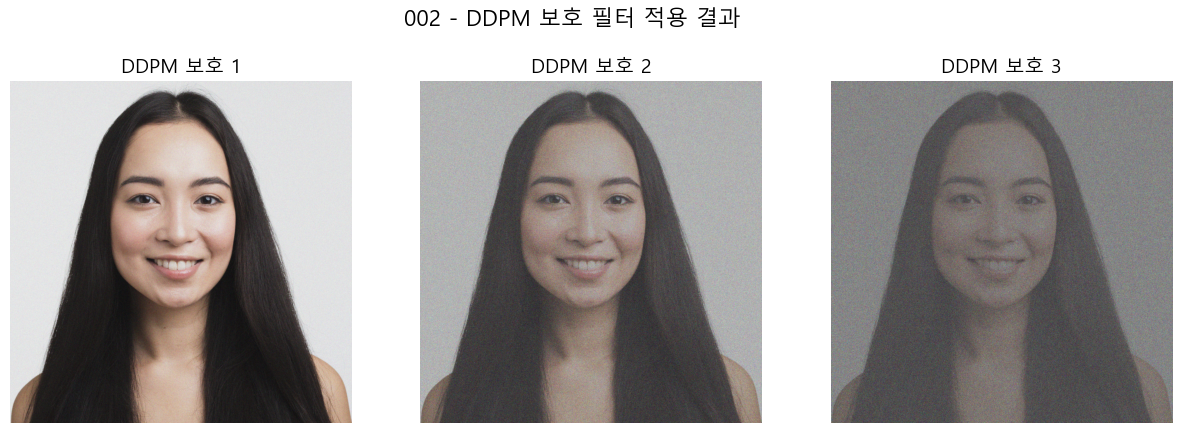

📌 **DDPM_1**
  - PSNR: 28.49
  - SSIM: 0.1267
  - AI 모델 예측: 903

📌 **DDPM_2**
  - PSNR: 28.12
  - SSIM: 0.0219
  - AI 모델 예측: 903

📌 **DDPM_3**
  - PSNR: 28.00
  - SSIM: 0.0119
  - AI 모델 예측: 501


🎨 **SDN 모델**


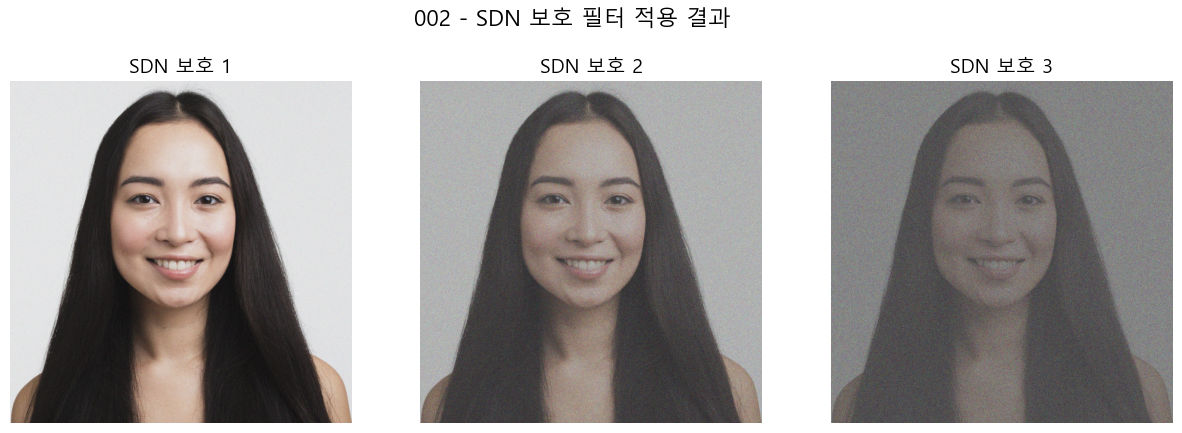

📌 **SDN_1**
  - PSNR: 28.49
  - SSIM: 0.1267
  - AI 모델 예측: 903

📌 **SDN_2**
  - PSNR: 28.12
  - SSIM: 0.0219
  - AI 모델 예측: 903

📌 **SDN_3**
  - PSNR: 28.00
  - SSIM: 0.0119
  - AI 모델 예측: 501


🎨 **SGN 모델**


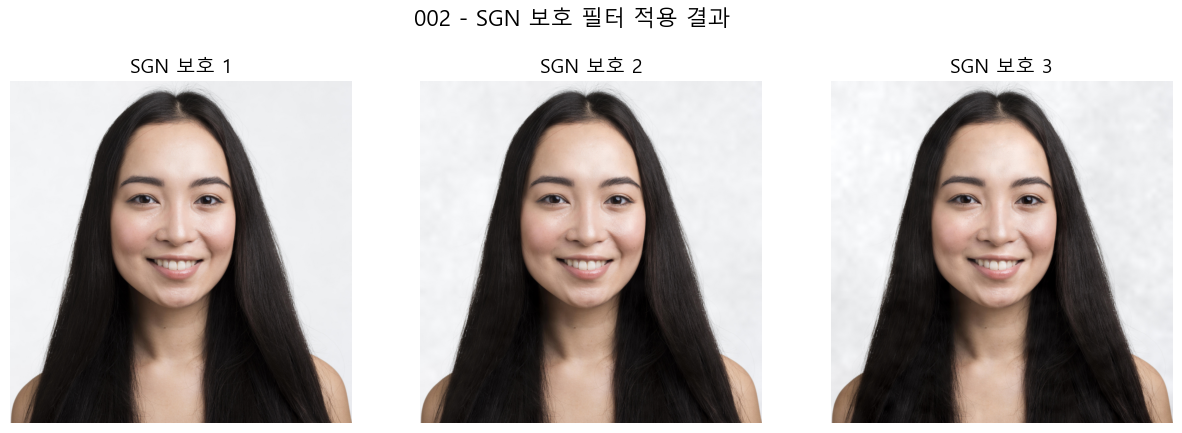

📌 **SGN_1**
  - PSNR: 44.11
  - SSIM: 0.9815
  - AI 모델 예측: 903

📌 **SGN_2**
  - PSNR: 40.12
  - SSIM: 0.9789
  - AI 모델 예측: 445

📌 **SGN_3**
  - PSNR: 35.63
  - SSIM: 0.9738
  - AI 모델 예측: 568



In [33]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torchvision.models as models
import cv2
from skimage.metrics import structural_similarity as ssim

# 🔥 Pre-trained AI 모델 (ResNet50) 로드
model = models.resnet50(pretrained=True)
model.eval()

def calculate_psnr_ssim(original, noisy):
    """PSNR 및 SSIM 계산"""
    original = np.array(original.convert("L"))  # 흑백 변환
    noisy = np.array(noisy.convert("L"))  # 흑백 변환

    # PSNR 계산
    mse = np.mean((original - noisy) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')

    # SSIM 계산
    ssim_value = ssim(original, noisy, data_range=noisy.max() - noisy.min())

    return psnr, ssim_value

def predict_image(image):
    """이미지를 ResNet 모델을 사용하여 분류"""
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가
    with torch.no_grad():
        output = model(image_tensor)
    return torch.argmax(output).item()

def extract_model_name(filename):
    """출력 파일명에서 모델명 추출 (_1_SGN.jpg → SGN)"""
    parts = filename.split("_")
    return parts[-1].split(".")[0]  # 확장자 제거

def validate_images(input_dir="./Output/"):
    """모든 이미지에 대해 PSNR, SSIM, AI 모델 예측 수행 및 출력"""
    image_dict = {}  # {원본이미지: {모델명: [노이즈 이미지1, 2, 3]}}
    
    # 이미지 파일 탐색
    image_paths = glob.glob(os.path.join(input_dir, "*_*_*.jpg"))  # _1_SGN.jpg 같은 형식
    for img_path in image_paths:
        img_name, _ = os.path.splitext(os.path.basename(img_path))  # 파일명 추출
        base_name = "_".join(img_name.split("_")[:-2])  # 원본 이미지명
        model_name = extract_model_name(img_name)  # 모델명
        noise_level = int(img_name.split("_")[-2])  # 노이즈 단계

        if base_name not in image_dict:
            image_dict[base_name] = {}
        if model_name not in image_dict[base_name]:
            image_dict[base_name][model_name] = {}

        image_dict[base_name][model_name][noise_level] = img_path  # 정렬

    # 검증 수행
    for base_name, models in image_dict.items():
        print(f"\n📌 **{base_name} (원본 이미지) 검증 결과**")
        original_img = Image.open(os.path.join("./Input/", base_name + ".jpg")).convert("RGB")

        # 원본 AI 예측
        original_ai = predict_image(original_img)
        print(f"🔍 AI 모델 예측: {original_ai}")

        # 원본 이미지 출력
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(original_img)
        axes.set_title("원본 이미지", fontsize=14)
        axes.axis("off")
        plt.show()

        # 각 모델별 출력
        for model_name, noise_dict in models.items():
            print(f"\n🎨 **{model_name} 모델**")
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            protected_list = []
            psnr_ssim_values = {}
            ai_results = {}

            for i in range(1, 4):
                noisy_img = Image.open(noise_dict[i]).convert("RGB")
                protected_list.append(noisy_img)

                # PSNR & SSIM 계산
                psnr, ssim_value = calculate_psnr_ssim(original_img, noisy_img)
                psnr_ssim_values[i] = (psnr, ssim_value)

                # AI 모델 예측
                ai_results[i] = predict_image(noisy_img)

                axes[i-1].imshow(noisy_img)
                axes[i-1].set_title(f"{model_name} 보호 {i}", fontsize=14)
                axes[i-1].axis("off")

            plt.suptitle(f"{base_name} - {model_name} 보호 필터 적용 결과", fontsize=16)
            plt.show()

            # PSNR, SSIM, AI 예측 결과를 이미지별로 출력
            for i in range(1, 4):
                psnr, ssim_value = psnr_ssim_values[i]
                ai_label = ai_results[i]

                print(f"📌 **{model_name}_{i}**")
                print(f"  - PSNR: {psnr:.2f}")
                print(f"  - SSIM: {ssim_value:.4f}")
                print(f"  - AI 모델 예측: {ai_label}\n")

# 실행
validate_images()
